<a href="https://colab.research.google.com/github/belindalombard/BertMLProject/blob/master/Relevance_Model_Early_Stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Annotation - BERTimbau - Relevance


---

For this research project, we will be utilizing the BERTimbau pretrained model. See citation below: \

@inproceedings { \
  souza2020bertimbau, \
  author    = {F{\'a}bio Souza and Rodrigo Nogueira and Roberto Lotufo}, \
  title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese}, \
  booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)}, \
  year      = {2020} \
}


## Set Up
Mount to drive to access files for training the model:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

Install transformers:


In [2]:
!pip install transformers

Import libraries:

In [3]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, pipeline
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler, Dataset
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import os
import torch
from torch.optim import AdamW
import seaborn as sns
import random
import gc

Package versions:

In [4]:
print(f"Transformers version: {transformers.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")

Transformers version: 4.42.4
Pandas version: 2.1.4
Numpy version: 1.26.4
PyTorch version: 2.3.1+cu121
Scikit-learn version: 1.3.2
Seaborn version: 0.13.1


### Connect to GPU
Connect to GPU if available:

In [5]:
import torch

# If there's a GPU available:
if torch.cuda.is_available():

    # Use GPU
    device = torch.device("cuda")

    print("There are available GPU(s).") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not

else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

There are available GPU(s).
We will use the GPU: Tesla T4


## GLOBAL VARIABLES - MODEL

Below are global variables related to training the model. \
This will make the code more maintainable and easier to experiment with new values.

Seed values used: [66, 109, 85, 42, 120, 172, 239, 19, 124, 48, 83, 184, 47, 160, 238, 49, 209, 110, 174, 118]

In [6]:
import os

MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'
NUM_CLASSES = 2

SEED_VAL = 66

NUM_FOLDS = 5
NUM_EPOCHS = 5

L_RATE = 2e-5 # Testar novos valores
MAX_LEN = 256 # Testar novos valores
BATCH_SIZE = 32 # Testar novos valores
EPS = 1e-8 # Testar novos valores
# regression epsylon

NUM_CORES = os.cpu_count()

## GLOBAL VARIABLES - DATA
FILE_PATH = path to data file that will be used \

RELEVANCE = name of column representing relevance \
RELEVANCE_ID = column value that represents (relevance == True) \

POST = name of column representing the content of the tweet \
POST_DATE = name of column representing the post date \
POST_ID = name of column representing the tweet id

YEAR = year of when the dataset is from (to be used for file/folder naming)

In [7]:
FILE_PATH = '/content/drive/MyDrive/pesquisa-usp/relevant_tweets_2020-12-31.csv'
FOLDER_PATH = ('/content/drive/MyDrive/pesquisa-usp/relevance/seed_' + str(SEED_VAL) + '/')

RELEVANCE = 'relevance'
RELEVANCE_ID = 'relevant'

POST = 'content'
POST_DATE = 'post_date'
POST_ID = 'tweet_id'

YEAR = '2020'


## Load BERT

Here, we will load BertForSequenceClassification. \
This is a pre-trained BERT model with a single linear classification layer on top.

In [8]:
from transformers import BertForSequenceClassification


model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = NUM_CLASSES,
          output_attentions = False,
          output_hidden_states = False
        )


# Send the model to the device:
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e



---


We will also save the path to this model so that it can be accessed at the start of the training loop.\
Variation of performance was observed when a new BertForSequenceClassification model is loaded.

We plan to compare pre-training performance with post-training performance. \
Thus, we want to ensure that the model being trained is the same model that was previously evaluated.

In [9]:
model_name = 'original_model.bin'

torch.save(model.state_dict(), model_name)
print('Saved model as', model_name)

Saved model as original_model.bin


## Load Tokenizer

Load BERT tokenizer:

In [10]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=False)

Loading BERT tokenizer...


## Prepare Dataset

---

Load the cvs file of the dataset chosen to train the model:

In [11]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

df = pd.read_csv(FILE_PATH)

Run this cell to display the dataset:

In [12]:
df

,tweet_id,content,post_date,relevance
0,A522,A cabeça pensa onde o pé pisa. Quem governa de...,2020-09-15,relevant
1,A457,Sarto vai fazer um grande Programa de Enfrenta...,2020-11-20,relevant
2,A445,A Câmara dos Deputados votou hoje a MP que tra...,2020-12-18,relevant
3,A546,Tirar Bolsonaro do poder é uma questão de vida...,2020-11-10,relevant
4,A847,E a LIESA decidiu adiar os desfiles do #Carnav...,2020-09-24,relevant
...,...,...,...,...
2997,B2717,"""Estou exigindo a questão da cloroquina."" Algu...",2020-05-14,relevant
2998,B4586,#FeijoadaBeneficente | Participei neste sábado...,2020-03-09,irrelevant
2999,B4134,Aracaju tem um legado. Legado de desenvolvimen...,2020-06-10,irrelevant
3000,B2705,Estudo publicado pelo Imperial College estima ...,2020-04-01,irrelevant


###  Parsing

Display the class distribution of the dataset:

In [13]:
print("Tweet_Relevancies", YEAR + ":")

print(df[RELEVANCE].value_counts())

Tweet_Relevancies 2020:
relevance
irrelevant    1595
relevant      1407
Name: count, dtype: int64


Here, we will recode the class names to use integers instead of strings:

In [14]:
def condition(x):
    if x == RELEVANCE_ID:
        return 1
    else:
        return 0

df[RELEVANCE] = df[RELEVANCE].apply(condition)


We will illustrate this recoding of class names by displaying the class distributions again:

In [15]:
print(df[RELEVANCE].value_counts())

relevance
0    1595
1    1407
Name: count, dtype: int64


Plot overall class distribution and save the graph as a png:

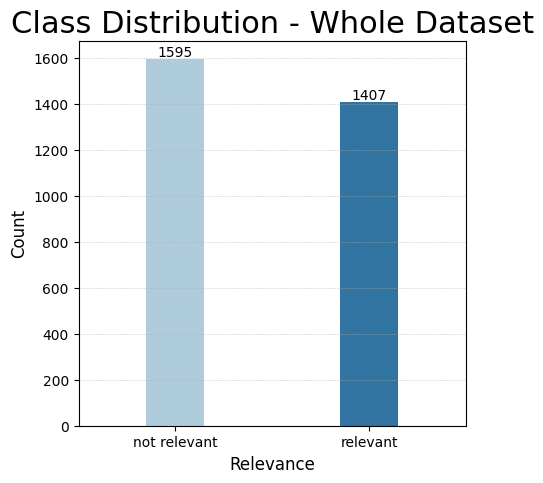

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
ax = sns.countplot(df,
                   x=RELEVANCE,
                   hue=RELEVANCE,
                   palette="Paired",
                   width=0.3,
                   legend=False
                  )

plt.title("Class Distribution - Whole Dataset",fontsize=22)
plt.xlabel('Relevance',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.xticks([0,1],['not relevant', 'relevant'])

plt.grid(True,axis='y',
         linestyle=':',
         linewidth=0.5
        )

for i in ax.containers:
    ax.bar_label(i,)


plt.savefig(FOLDER_PATH+'ClassDistribution_WholeDataset_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )

### Split Train/Test Sets

Here, we separate **10%** of the total observations for the **test set**. \\
We use train_test_split so that the **data is shuffled** before splitting, using a seed (SEED_VAL) for the random state. \\
We use a stratifier to ensure that **class distribution proportions are maintained** in both sets. \\

**NOTE:** Train and Test sets should be tokenized and processed separately to avoid data leakage. \\

In [17]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
                                     test_size = 0.1, # 10% for the test set
                                     stratify = df[RELEVANCE], # maintain class proportions
                                     random_state = SEED_VAL # ensures reproducibility of results
                                    )

Display class distributions of each set:

In [18]:
print("Training Set Class Distribution:")
print(df_train[RELEVANCE].value_counts())
print("\nTest Set Class Distribution:")
print(df_test[RELEVANCE].value_counts())

Training Set Class Distribution:
relevance
0    1435
1    1266
Name: count, dtype: int64

Test Set Class Distribution:
relevance
0    160
1    141
Name: count, dtype: int64


Here, we plot class distributions across training/test sets and save graph as a png. \
We add the DATASET column for plotting purposes, it will not be relevant later.

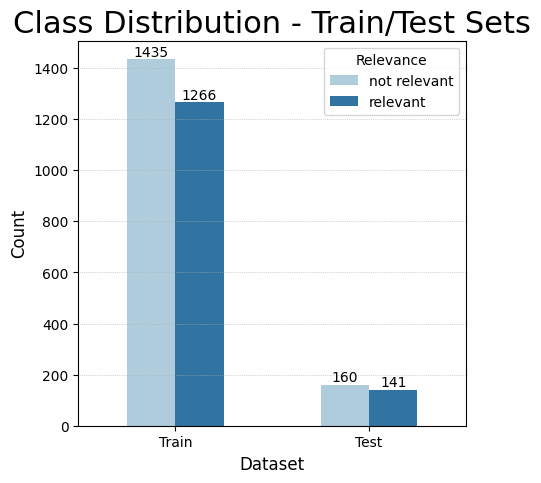

In [19]:
df_train['DATASET'] = 'Train'
df_test['DATASET'] = 'Test'

# Combine the two DataFrames
df_combined = pd.concat([df_train, df_test])

# Plot class distributions in a single plot
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='DATASET',
                   hue=RELEVANCE,
                   data=df_combined,
                   palette="Paired",
                   width=0.5
                  )

plt.title('Class Distribution - Train/Test Sets', fontsize=22)
plt.xlabel('Dataset',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(title='Relevance', labels=['not relevant', 'relevant'])

plt.grid(True,axis='y',
         linestyle=':',
         linewidth=0.5
        )

for i in ax.containers:
    ax.bar_label(i,)

plt.savefig(FOLDER_PATH+'ClassDistribution_TrainTestSplit_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )

### Custom Dataset Class

This class will be used to tokenize sentences:

In [20]:
from torch.utils.data import Dataset

class TweetDataset(Dataset):
  def __init__(self, df):
    self.df_data = df

  def __getitem__(self, index):
    # Get the sentences from the dataframe
    sentence = self.df_data.iloc[index][POST]

    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Build attn. masks.
                                         return_tensors = 'pt', # Return pytorch tensors
                                        )


    # Torch Tensors

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the Target into a tensor

    target = torch.tensor(self.df_data.iloc[index][RELEVANCE])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)

### Create Test Dataloader

Here, we create an object of the TweetDataset to tokenize all sentences in our curated dataset. \
We then create a DataLoader object to split the test data into batches, which will be used for the testing loop later one.

In [21]:
from torch.utils.data import DataLoader

df_test.reset_index(drop=True, inplace=True)
test_data = TweetDataset(df_test)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_CORES
                            )

print('Test Dataloader Length:',len(test_dataloader))
print('\nIndex Range of Test Dataloader:', df_test.index)
print('\nFirst 5 Rows of Test Dataloader:')
print(df_test.head())


Test Dataloader Length: 10

Index Range of Test Dataloader: RangeIndex(start=0, stop=301, step=1)

First 5 Rows of Test Dataloader:
  tweet_id                                            content   post_date  \
0    B5569  A ação chamada Mãos Sempre Limpas faz parte do...  2020-05-05   
1    B1321  Parem de falar em imunidade de rebanho. A maio...  2020-07-12   
2    B3382  VERGONHA!\nVenezuela 🇻🇪 denunciou o Brasil na ...  2020-06-16   
3     A259  @As300Raposas Triste realidade. O prefeito de ...  2020-12-08   
4      A44  Vacina contra o sarampo: em MG, só 35% do públ...  2020-10-28   

   relevance DATASET  
0          0    Test  
1          1    Test  
2          0    Test  
3          1    Test  
4          0    Test  


## Metrics Function

To return evaluation scores, we will use the **classification_report_with_accuracy_score** as defined below.

Arguments: \
- **preds** = a flat list of the predictions of the model as integers
- **labels** = a flat list of the true classification of the corresponding predictions

Returns: \
- **df_class_report** = a DataFrame of the classification report made using **preds** and **labels**, which includes:

 - *precision*, *recall*, and *F1-score* for each class.

 - *macro average* and *weighted average* between both classes for precision, recall and F1-score.


 - **overall_accuracy** = overall *accuracy* of the model.

 All metrics are rounded to the closest 2 decimals.

In [22]:
from sklearn.metrics import classification_report

def classification_report_with_accuracy_score(preds, labels):
    report = classification_report(labels, preds, output_dict = True, zero_division = 0)

    df_class_report = pd.DataFrame(report).transpose()
    df_class_report = df_class_report.round(decimals=2) # for better readibility

    overall_accuracy = np.sum(preds == labels) / len(labels)
    rounded_accuracy = overall_accuracy.round(decimals=2)

    return df_class_report, rounded_accuracy

## Evaluate the BERTimbau Pre-Trained Model



Here, we will evaluate how BERTimbau (a pre-trained model) performs before being trained on our curated dataset. \
We refer to the process of specifically training BERTimbau on our dataset as fine-tuning, which will be done later on.  

\\
We will evaluate performance using the following metrics: \\
- **Accuracy**: correct predictions/total number of instances
- **Precision**: percentage of instances that the model classified correctly for a given class
- **Recall**: percentage of instances of a given class that were classified correctly
- **F1-Score**: harmonic mean of precision and recall
- **Confusion Matrix**: represents number of actual outputs versus predicted outputs


###Test batches

Use the test_dataloader to evaluate BERTimbau's performance, testing in batches:

In [23]:
model.eval()
torch.set_grad_enabled(False)

for i, test_batch in enumerate(test_dataloader):
  test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
  print(test_status, end='\r')

  b_input_ids = test_batch[0].to(device)
  b_input_mask = test_batch[1].to(device)
  b_token_type_ids = test_batch[2].to(device)


  outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  return_dict = False)

  preds = outputs[0]
  test_preds = preds.detach().cpu().numpy()


  if i == 0:  # first batch
    stacked_test_preds = test_preds

  else:
    stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Each prediction returned by the model is a tuple - the logits are still raw.

The first value of the tuple represents the score given for Class 0, and the second value represents the score given for Class 1. \\
To get the real prediction, we take the max of both values to know whether the model's final prediction was Class 0 or Class 1. \\

For clarity, we will illustrate this below:

In [24]:
print("First 5 predictions as a raw logit tuple:\n", stacked_test_preds[0:6])
final_preds = np.argmax(stacked_test_preds, axis=1)
print("\nFirst 5 predictions final decisions after taking the max:\n", final_preds[0:6])


First 5 predictions as a raw logit tuple:
 [[-0.24359272  0.341408  ]
 [ 0.03330736 -0.6060668 ]
 [-0.08569829 -0.5116743 ]
 [-0.09383801 -0.5067471 ]
 [ 0.13513389 -0.65310025]
 [-0.0698074  -0.46785486]]

First 5 predictions final decisions after taking the max:
 [1 0 0 0 0 0]


###Performance Scores

Now, we can calculate the model's performance scores using the function that was previously defined. \

It must be noted that when reloading the model and rerunning the tests, a small fluctuation of values was observed in the performance scores. \
It was ensured that the Train/Test split of the dataset and the tokenization of the test set were the same in all trials.


In [25]:
labels = df_test[RELEVANCE]

report, accuracy = classification_report_with_accuracy_score(final_preds, labels)

print(report)

              precision  recall  f1-score  support
0                  0.52    0.89      0.65    160.0
1                  0.31    0.06      0.10    141.0
accuracy           0.50    0.50      0.50      0.5
macro avg          0.41    0.47      0.37    301.0
weighted avg       0.42    0.50      0.39    301.0


Plot report as a table and save figure as a png:

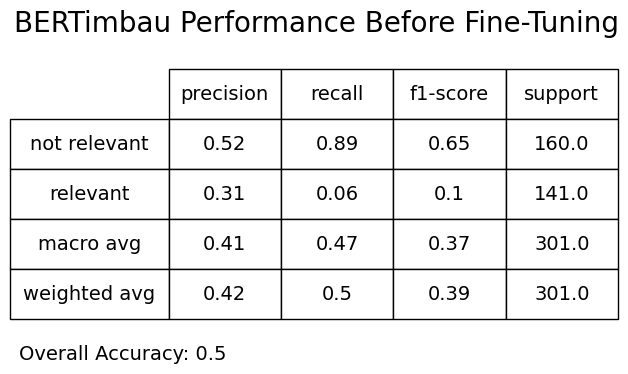

In [26]:
without_acc = report.loc[['0', '1', 'macro avg', 'weighted avg']]
without_acc = without_acc.rename(index={'0': 'not relevant', '1': 'relevant'})

fig, ax = plt.subplots(figsize=(2,4))
ax.axis('off')
table = pd.plotting.table(ax,
                          without_acc,
                          loc='right',
                          cellLoc='center',
                          rowLoc='center'
                         )

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.9, 3)
plt.title('BERTimbau Performance Before Fine-Tuning',
          loc='left',
          fontsize=20
         )

acc_str = 'Overall Accuracy: '+ str(accuracy)
fig.text(0.67, 0.08,
         acc_str,
         ha='center',
         fontsize=14
        )


plt.savefig(FOLDER_PATH+'PerformanceTable_PreTrainedModel_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )

Plot the confusion matrix to visualize the model's predictions against their true value, and save the figure as a png:

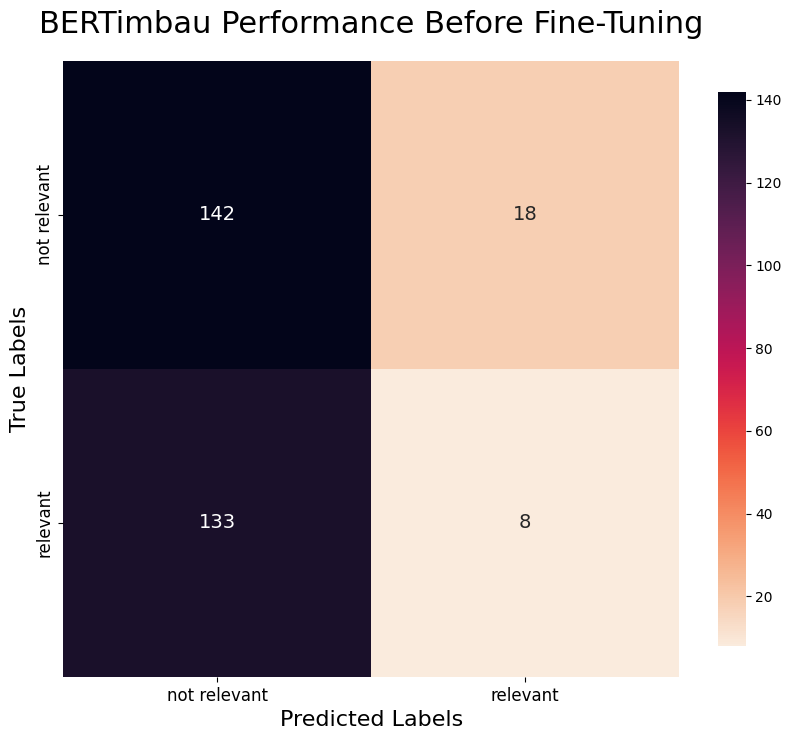

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


confusion_matrix = confusion_matrix(df_test[RELEVANCE], final_preds)

fig = plt.figure(figsize=(10, 8))

ax = sns.heatmap(confusion_matrix,
                 annot=True,
                 cmap="rocket_r",
                 fmt = '.0f',
                 yticklabels=['not relevant', 'relevant'],
                 xticklabels=['not relevant', 'relevant'],
                 square=True,
                 annot_kws={"size": 14},
                 cbar=True,
                 cbar_kws={'shrink': 0.9}
                )

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add title and labels
plt.title('BERTimbau Performance Before Fine-Tuning',
          fontsize = 22,
          loc = 'center',
          pad = 20
         )

plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.savefig(FOLDER_PATH+'ConfusionMatrix_PreTrainedModel_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )


##Train Model

We will now train BERTimbau on our curated dataset.\
The goal is to achieve significantly better evaluation scores compared to the pre-trained model's performance.

###Set the Seed

The seed will ensure reproducibility of these experiments:

In [28]:
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

###Remove Warnings

In [29]:
from transformers import AdamW
import random
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

# Remove Warnings

from transformers import logging

logging.set_verbosity_warning()

###Create Folds

In order to train the model, we must split the training dataset into train/validation sets.\
To do this, we will create folds such that each fold will have a different randomized (but seed controlled) dataset split.

In [30]:
skf = StratifiedKFold(n_splits = NUM_FOLDS,
                      shuffle = True,
                      random_state = SEED_VAL)

targets = df_train[RELEVANCE]

folds_list = skf.split(df_train,targets)

###Class Distribution Across Folds

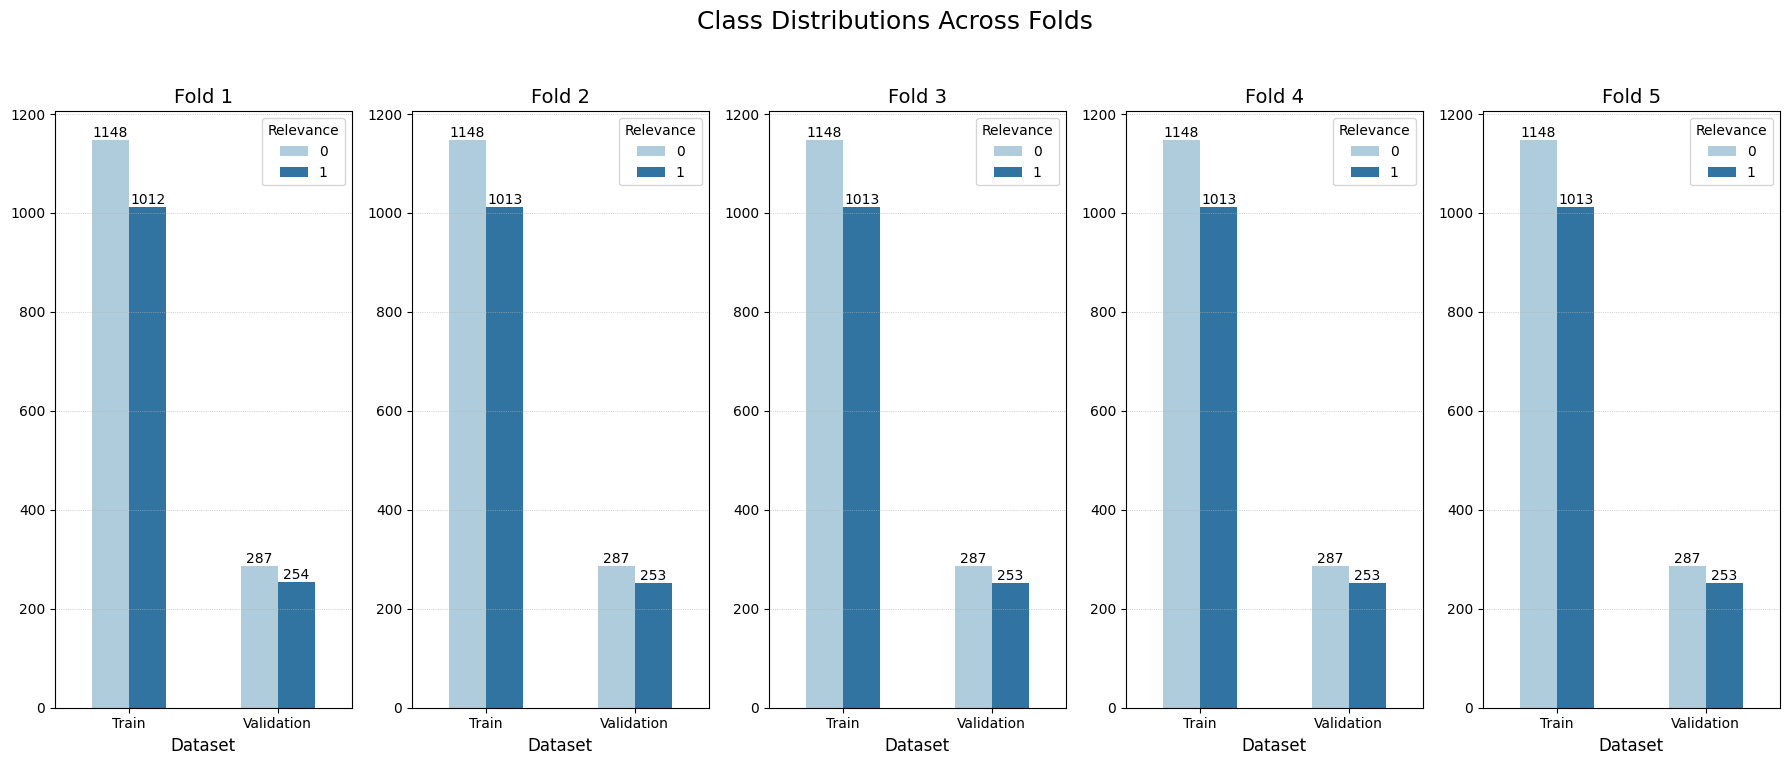

In [31]:
# create a figure with subplots
fig, axes = plt.subplots(1,NUM_FOLDS, figsize=(18, 8))
fig.suptitle('Class Distributions Across Folds', fontsize=18)

for n, (train_index, val_index) in enumerate(skf.split(df_train,targets)):
  train = df_train.iloc[train_index,:]
  validation = df_train.iloc[val_index,:]

  # Group the datasets to be plotted:
  train.loc[:, 'DATASET'] = 'Train'
  validation.loc[:, 'DATASET'] = 'Validation'
  df_combined = pd.concat([train, validation])
  # plt.figure(figsize=(5, 5))

  sub_fig = axes[n]
  ax = sns.countplot(ax=sub_fig, x='DATASET', hue=RELEVANCE, data=df_combined, palette="Paired", width=0.5)

  title = 'Fold ' + str(n+1)
  sub_fig.set_title(title, fontsize=14)

  # Set labels and legend
  sub_fig.set_xlabel('Dataset', fontsize=12)
  sub_fig.set_ylabel('')
  sub_fig.legend(title='Relevance', loc='upper right')
  sub_fig.grid(True, axis='y', linestyle=':', linewidth=0.5)


  for i in ax.containers:
      ax.bar_label(i,)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FOLDER_PATH+'ClassDistribution_AcrossFolds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

###Lists for Performance Scores/Data

We will use the list below to store performance scores of all epochs across all folds.

Each epoch is a dictionary containing:
- fold number
- epoch number

- total train loss
- average train loss
- total validation loss
- average validation loss

- classification report
- validation accuracy

In [32]:
training_stats = []

###Training Loop

We train the model in NUM_FOLDS folds, each of which will have NUM_EPOCHS epochs.


Each fold loads a new pre-trained BERTimbau model to fine-tune. \

Each epoch in this fold will train the model on the fold's train set, followed by an evaluation of the model using the fold's validation set. \
\
If its Macro F1-score is better than the other epochs, that model will be saved using: \
  - model_name = 'fold_' + str(fold_index) + '.bin'
  - torch.save(model.state_dict(), model_name)

We will also use a variable to store the name of the best model out of all folds, so that we can load it later for testing.






In [33]:
best_fold_path = ''

In [ ]:
%%time

for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,targets)):
  print('\n################## Fold Model Number', str((fold_index+1)) + ' / ' + str(NUM_FOLDS), '##################')

  # ..................................................
  # Defining Dataloaders of Training and Validation
  # ..................................................

  # Train and Validation Sets
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Reseting Indices so it will work
  train = train.reset_index(drop = True)
  val = val.reset_index(drop = True)


  # Tokenizing and Transforming Inputs (att masks, labels, etc.)
  train_data = TweetDataset(train)
  val_data = TweetDataset(val)

  # Train/Validation Split for this Fold:
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_CORES)

  # ..................................................
  # List for Epoch Evaluation Metric:
  # ..................................................
  fold_f1_macro_list = []

#------------------------------------------------------------------------------
  for epoch in range(NUM_EPOCHS):
#------------------------------------------------------------------------------

    #......................
    # Loading Fold Model
    #......................

    if epoch == 0:

      # Load model from pre-training evaluation:
      model.load_state_dict(torch.load('original_model.bin'))

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = EPS
                       )

    else:
      # Load the fold's model:
      path_model = 'fold_' + str(fold_index+1) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

        model.to(device)


    # ==========================================================================
    #               Training
    # ==========================================================================
    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))
    print(" ")
    print('\nTraining...')
    print('')

    # Put the model into train mode:
    model.train()

    # Turn gradient calculations on:
    torch.set_grad_enabled(True)


    # .......................................................
    # Defining Variables to Track This Epoch's Performance
    # .......................................................

    # overall stats:
    epoch_stats = {'fold': fold_index + 1,
                   'epoch': epoch + 1}

    total_macro_f1 = 0
    avg_macro_f1 = 0

    # train stats:
    total_train_loss = 0
    avg_train_loss = 0

    # validation stats:
    total_val_loss = 0
    avg_val_loss = 0

    # ..................
    # Train the Model
    # ..................

    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Calculate loss:
      batch_loss = loss.item()

      total_train_loss += batch_loss


      # Zero the gradients:
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients:
      loss.backward()


      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


      # Update Weights:
      optimizer.step()   # for GPU

      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)   #for TPU


    # ........................................
    # Update Training Performance Variables
    # ........................................

    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)


    # .......................................
    # Add Scores to Epoch Stats Dictionary
    # .......................................

    epoch_stats['total_train_loss'] = total_train_loss
    epoch_stats['avg_train_loss'] = avg_train_loss



    # ==========================================================================
    #               Validation
    # ==========================================================================
    print(" ")
    print('=============================================')
    print('\nValidation...')
    print(' ')

    # Put the model in evaluation mode:
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Lists to accumulate all predictions and their corresponding labels:
    stacked_val_preds = []
    val_targets = []


    # .....................
    # Validate the Model
    # .....................

    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')


      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)


      # Calculate loss:
      batch_loss = loss.item()
      total_val_loss += batch_loss


      # Move labels and predictions to the CPU:
      batch_targets = b_labels.to('cpu').numpy()
      batch_preds = logits.detach().cpu().numpy()


      # Append the labels and predictions to their lists:
      val_targets.extend(batch_targets)

      if j == 0:
        stacked_val_preds = batch_preds
      else:
        stacked_val_preds = np.vstack((stacked_val_preds, batch_preds))


      batch_preds = np.argmax(batch_preds, axis = 1)

      total_macro_f1 += f1_score(batch_targets,
                                 batch_preds,
                                 average = 'macro'
                                )
      # usage: sklearn.metrics.f1_score(y_true, y_pred)


    # ..........................................
    # Update Validation Performance Variables
    # ..........................................

    avg_val_loss = total_val_loss / len(val_dataloader)

    avg_macro_f1 = total_macro_f1 / len(val_dataloader)


    print('Total Validation loss:' ,total_val_loss)
    print('Average Validation Loss: ', avg_val_loss)

    print("Macro F1-score: {0:.2f}".format(avg_macro_f1))



    stacked_val_preds = np.argmax(stacked_val_preds, axis=1)

    class_report, val_acc = classification_report_with_accuracy_score(stacked_val_preds, val_targets)


    print('Validation accuracy: ', val_acc)
    print('Classification Report: \n', class_report)



    # .......................................
    # Add Scores to Epoch Stats Dictionary
    # .......................................
    epoch_stats['total_val_loss'] = total_val_loss
    epoch_stats['avg_val_loss'] = avg_val_loss
    epoch_stats['val_accuracy'] = val_acc
    epoch_stats['f1_macro'] = avg_macro_f1
    epoch_stats['report'] = class_report

    # .........................................
    # Add Epoch Stats to Training Stats List
    # .........................................
    training_stats.append(epoch_stats)


    # ......................
    # Save the best model
    # ......................

    if epoch == 0:

      # Save the Model:
      model_name = 'fold_' + str(fold_index+1) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as', model_name)



    else:

      stop = total_val_loss > total_train_loss


      if not stop:

        model_name = 'fold_' + str(fold_index+1) + '.bin'
        torch.save(model.state_dict(), model_name)

        print('F1-Macro improved. Saved model as', model_name)


      else:
        # remove overfitted epoch stats:
        training_stats.pop()

        print('Model overfitted at epoch', str(epoch+1) + '. Model was not saved.')
        break


    # Use the garbage collector to save memory:
    gc.collect()



################## Fold Model Number 1 / 5 ##################
============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 26.91392744332552
Average Train Loss:  0.39579305063714
 

Validation...
 
Total Validation loss: 2.9403230771422386
Average Validation Loss:  0.17296018100836696
Macro F1-score: 0.94
Validation accuracy:  0.94
Classification Report: 
               precision  recall  f1-score  support
0                  0.92    0.97      0.95   287.00
1                  0.96    0.91      0.94   254.00
accuracy           0.94    0.94      0.94     0.94
macro avg          0.94    0.94      0.94   541.00
weighted avg       0.94    0.94      0.94   541.00
Saved model as fold_1.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 8.844493412412703
Average Train Loss:  0.13006607959430447
 

Validation...
 
Total Validation loss: 2.50203007273376
Average Validation Loss:  0.14717823957257412
Macro F1-score: 0.95
Validation accuracy:  0.95
Classification Report: 
               precision  recall  f1-score  support
0                  0.96    0.95      0.95   287.00
1                  0.94    0.95      0.95   254.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.95    0.95      0.95   541.00
weighted avg       0.95    0.95      0.95   541.00
F1-Macro improved. Saved model as fold_1.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 3.95617375546135
Average Train Loss:  0.05817902581560809
 

Validation...
 
Total Validation loss: 3.160639167064801
Average Validation Loss:  0.1859199510038118
Macro F1-score: 0.95
Validation accuracy:  0.95
Classification Report: 
               precision  recall  f1-score  support
0                  0.96    0.95      0.96   287.00
1                  0.94    0.96      0.95   254.00
accuracy           0.95    0.95      0.95     0.95
macro avg          0.95    0.95      0.95   541.00
weighted avg       0.95    0.95      0.95   541.00
F1-Macro improved. Saved model as fold_1.bin
============== Epoch 4 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 2.2195062820101157
Average Train Loss:  0.03263979826485464
 

Validation...
 
Total Validation loss: 3.906984675617423
Average Validation Loss:  0.22982262797749548
Macro F1-score: 0.96
Validation accuracy:  0.96
Classification Report: 
               precision  recall  f1-score  support
0                  0.95    0.97      0.96   287.00
1                  0.96    0.94      0.95   254.00
accuracy           0.96    0.96      0.96     0.96
macro avg          0.96    0.95      0.96   541.00
weighted avg       0.96    0.96      0.96   541.00
Model overfitted at epoch 4. Model was not saved.

################## Fold Model Number 2 / 5 ##################
============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 26.136789232492447
Average Train Loss:  0.3843645475366536
 

Validation...
 
Total Validation loss: 2.5085590556263924
Average Validation Loss:  0.1475622973897878
Macro F1-score: 0.94
Validation accuracy:  0.94
Classification Report: 
               precision  recall  f1-score  support
0                  0.95    0.94      0.95   287.00
1                  0.93    0.94      0.94   253.00
accuracy           0.94    0.94      0.94     0.94
macro avg          0.94    0.94      0.94   540.00
weighted avg       0.94    0.94      0.94   540.00
Saved model as fold_2.bin
============== Epoch 2 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 9.118103437125683
Average Train Loss:  0.13408975642831886
 

Validation...
 
Total Validation loss: 2.1439935052767396
Average Validation Loss:  0.1261172650162788
Macro F1-score: 0.96
Validation accuracy:  0.96
Classification Report: 
               precision  recall  f1-score  support
0                  0.98    0.95      0.97   287.00
1                  0.95    0.98      0.96   253.00
accuracy           0.96    0.96      0.96     0.96
macro avg          0.96    0.97      0.96   540.00
weighted avg       0.97    0.96      0.96   540.00
F1-Macro improved. Saved model as fold_2.bin
============== Epoch 3 / 5 ==============
 

Training...



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


##Model Evaluation

### Prepare Data

Convert the training_stats dictionary into a dataframe that will be used for data visualization:

In [ ]:
pd.set_option('display.precision', 2)

df = pd.DataFrame(training_stats)


Save the data frame as cvs and excel files:

In [ ]:
path = FOLDER_PATH + 'training_stats_seed'+ str(SEED_VAL) + '.cvs'
df.to_csv(path)

path = FOLDER_PATH + 'training_stats_seed'+ str(SEED_VAL) + '.xlsx'
df.to_excel(path)

Display the dataframe to see what it looks like:

In [ ]:
df

### Compare Folds

Group the training stats dataframe by folds and filter out losses columns:




In [ ]:
folds_loss = df.groupby('fold')[['total_train_loss','avg_train_loss','total_val_loss', 'avg_val_loss']].mean()
folds_loss = folds_loss.reset_index()

In [ ]:
folds_loss

Plot the losses of each fold:

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='fold', y='total_train_loss', data=folds_loss, marker='o', label='Total Train Loss')
sns.lineplot(x='fold', y='avg_train_loss', data=folds_loss, marker='o', label='Average Train Loss')
sns.lineplot(x='fold', y='total_val_loss', data=folds_loss, marker='o', label='Total Val Loss')
sns.lineplot(x='fold', y='avg_val_loss', data=folds_loss, marker='o', label='Average Val Loss')


plt.title('Training and Validation Losses Across Folds', fontsize=20)

plt.xlabel('Fold',fontsize=16)
plt.xticks(folds_loss['fold'], fontsize=12)
plt.ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Training_Validation_Losses_Across_Folds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Group the training stats data frame by folds and filter out the validation accuracy column:

In [ ]:
folds_acc = df.groupby('fold')['val_accuracy'].mean()
folds_acc = folds_acc.reset_index()

In [ ]:
folds_acc

Plot validation accuracy across folds:

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(x='fold', y='val_accuracy', data=folds_acc, marker='o')


plt.title('Validation Accuracy Across Folds',fontsize=20)

plt.xlabel('Fold', fontsize = 16)
plt.xticks(folds_acc['fold'],fontsize=12)
plt.ylabel('Percentage', fontsize=16)
plt.yticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1],fontsize=12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Validation_Accuracy_Across_Folds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Plot f1-macro scores across folds:

In [ ]:
folds_f1 = df.groupby('fold')['f1_macro'].mean()
folds_f1 = folds_f1.reset_index()

In [ ]:
folds_f1

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(x='fold', y='f1_macro', data=folds_f1, marker='o')


plt.title('Mean Macro F1-Score Across Folds',fontsize=20)

plt.xlabel('Fold', fontsize = 16)
plt.xticks(folds_f1['fold'],fontsize=12)
plt.ylabel('')
plt.yticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1],fontsize=12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Macro_F1_Across_Folds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

### Compare Epochs of The Best Fold

In [ ]:
folds_f1 = df.groupby('fold')['f1_macro'].max()
best = folds_f1.idxmax()
best

In [ ]:
folds_f1

In [ ]:
epochs = df[df['fold'] == best].groupby('epoch')[['total_train_loss','avg_train_loss','total_val_loss', 'avg_val_loss']].mean()
epochs = epochs.reset_index()
epochs

Compare epoch losses of the best fold:

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='total_train_loss', data=epochs, marker='o', label='Total Train Loss')
sns.lineplot(x='epoch', y='total_val_loss', data=epochs, marker='o', label='Total Val Loss')

plt.title('Total Losses Across Epochs', fontsize=20)

plt.xlabel('Epoch',fontsize=16)
plt.xticks(epochs['epoch'],fontsize=12)
plt.ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)

plt.legend(loc='upper right',fontsize = 12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Total_Losses_Across_Epochs_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='avg_train_loss', data=epochs, marker='o', label='Average Train Loss')
sns.lineplot(x='epoch', y='avg_val_loss', data=epochs, marker='o', label='Average Val Loss')


plt.title('Average Losses Across Epochs', fontsize=20)

plt.xlabel('Epoch',fontsize=16)
plt.xticks(epochs['epoch'],fontsize=12)
plt.ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)

plt.legend(loc='upper right',fontsize = 12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Average_Losses_Across_Epochs_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

### Evaluate the Best Fold on Test Set

Here, we evaluate the trained model of the best fold, using the same method used to evaluate the pre-trained model. \
We do this to see if there was significant improvement after being trained with the curated dataset.

In [ ]:
best_fold_path = 'fold_' + str(best) + '.bin'
best_fold_path

In [ ]:
# Load best model:
if os.path.exists(best_fold_path):
    model.load_state_dict(torch.load(best_fold_path))

else:
  print(f"Error: {best_fold_path} does not exist")

####Test Batches

In [ ]:
model.eval()
torch.set_grad_enabled(False)

for i, test_batch in enumerate(test_dataloader):
  test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
  print(test_status, end='\r')

  b_input_ids = test_batch[0].to(device)
  b_input_mask = test_batch[1].to(device)
  b_token_type_ids = test_batch[2].to(device)


  outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  return_dict = False)

  preds = outputs[0]
  test_preds = preds.detach().cpu().numpy()


  if i == 0:  # first batch
    stacked_test_preds = test_preds

  else:
    stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


# Round predictions to either 0 or 1
final_preds = np.argmax(stacked_test_preds, axis=1)

####Performance Scores

Like before, we can calculate the model's performance scores using the function that was previously defined. \

In [ ]:
labels = df_test[RELEVANCE]

report, accuracy = classification_report_with_accuracy_score(final_preds, labels)
# report is a DataFrame
print(report)

Get the missclassified tweets:

In [ ]:
posts = df_test[POST]
ids = df_test[POST_ID]

In [ ]:
posts[:5]

In [ ]:
print(df_test.head())

In [ ]:
ids[:5]

In [ ]:
wrong_preds = []

for i in range(len(labels)):
  predicted = final_preds[i]
  correct = labels[i]

  if predicted != correct:
    info = {'post id': ids[i],
            'post content': posts[i],
            'prediction': predicted,
            'correct label': correct}
    wrong_preds.append(info)

In [ ]:
df = pd.DataFrame(wrong_preds)
df

In [ ]:
path = FOLDER_PATH + 'wrong_predictions_seed'+ str(SEED_VAL) + '.cvs'
df.to_csv(path)

path = FOLDER_PATH + 'wrong_predictions_seed'+ str(SEED_VAL) + '.xlsx'
df.to_excel(path)

Plot report as a table and save figure as a png:

In [ ]:
without_acc = report.loc[['0', '1', 'macro avg', 'weighted avg']]
without_acc = without_acc.rename(index={'0': 'not relevant', '1': 'relevant'})

fig, ax = plt.subplots(figsize=(2,4))
ax.axis('off')
table = pd.plotting.table(ax, without_acc, loc='right',cellLoc='center',rowLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.9, 3)
plt.title('BERTimbau Performance After Fine-Tuning',
           loc='left',fontsize=20)
acc_str = 'Overall Accuracy: '+ str(accuracy.round(decimals=2))
fig.text(0.67, 0.08, acc_str, ha='center', fontsize=14)

plt.savefig(FOLDER_PATH+'PerformanceTable_TrainedModel_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Plot the confusion matrix to visualize the model's predictions against their true value, and save the figure as a png:

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


confusion_matrix = confusion_matrix(df_test[RELEVANCE], final_preds)
fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, annot=True,cmap="rocket_r", fmt = '.0f',
            yticklabels=['not relevant', 'relevant'],
            xticklabels=['not relevant', 'relevant'],square=True,
                 annot_kws={"size": 14},cbar=True,
                 cbar_kws={'shrink': 0.9})
# ax.set_font
# plt.yticks(rotation=0)
plt.xticks(fontsize=12)  # X-axis tick labels font size
plt.yticks(fontsize=12)
# Add title and labels
plt.title('BERTimbau Performance After Fine-Tuning', fontsize=22, loc='center',
          pad=20)
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.savefig(FOLDER_PATH+'ConfusionMatrix_TrainedModel_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)
